In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines,rpy2

cs224 
last updated: 2020-05-24 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
lifelines 0.24.2
rpy2 3.2.6


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Estimates of the severity of coronavirus disease 2019: a model-based analysis](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext)
    * duration from onset of symptoms to death to be 17·8 days (95% credible interval [CrI] 16·9–19·2)
    * to hospital discharge to be 24·7 days (22·9–28·1).
* [Estimating SARS-COV-2 infections](https://observablehq.com/@danyx/estimating-sars-cov-2-infections)
    * it takes on average 23 days from infection to death.
    * ~5 days from infection to symptoms and ~18 days from symptoms to death so we arrive at a default value of 23 days from infection to death
* [Characteristics of COVID-19 patients dying in Italy Report based on available data on March 20th, 2020](https://www.epicentro.iss.it/coronavirus/bollettino/Report-COVID-2019_20_marzo_eng.pdf)
    * Median number of days between onset of symptoms to death: 8
    * Median number of days between onset of symptoms to hospitalization: 4
* [Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext)
    * Time from illness onset to hospital admission, days	11·0 (8·0–14·0)
* [Coronavirus: how quickly do COVID-19 symptoms develop and how long do they last?](https://patient.info/news-and-features/coronavirus-how-quickly-do-covid-19-symptoms-develop-and-how-long-do-they-last)
    * ~5 days from infection to symptoms


* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

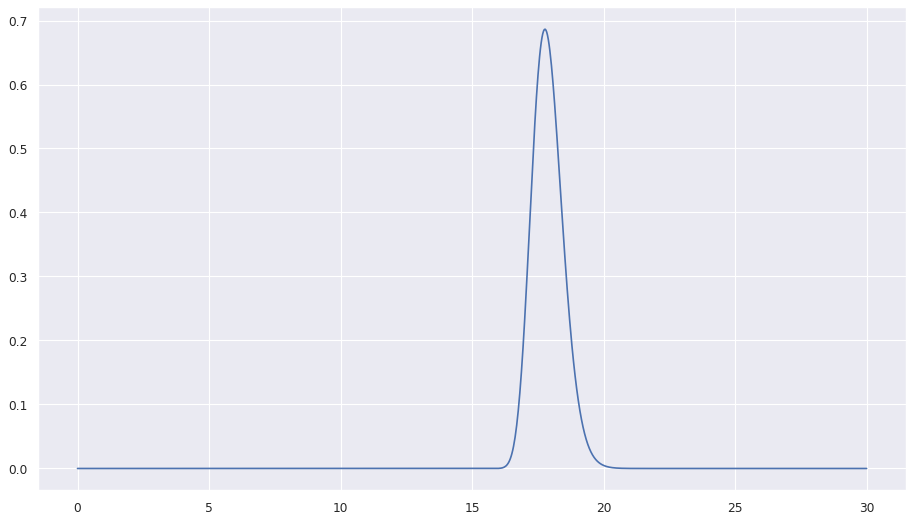

In [5]:
x = np.linspace(0.0,30.0,1000)
y = covid19.gamma_dist.pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

(5.52, 5.37, 5.67, 3.3, 5.433616189129196)


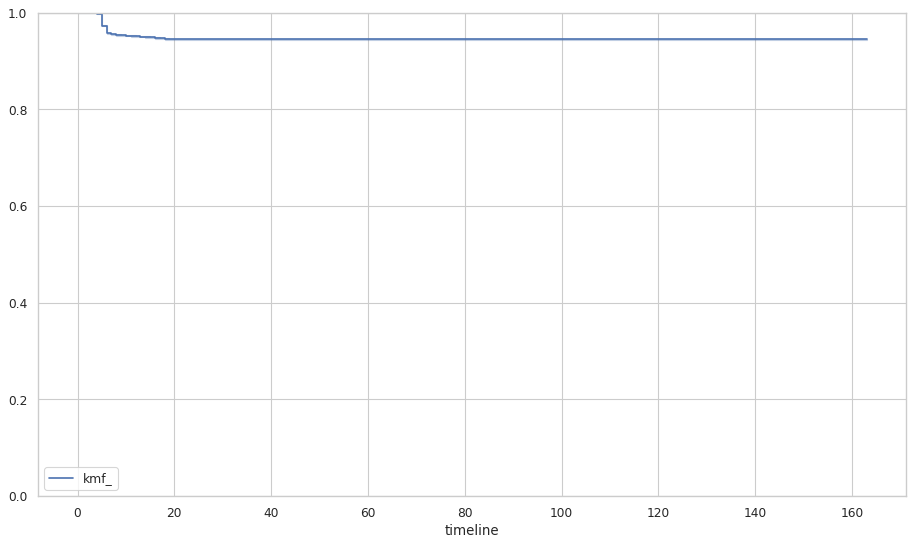

In [5]:
country_name, first_date, init_add = 'China', None, 0
# cfr_estimate, timeshift = covid19.calculate_delay_between_new_cases_and_death(country_name, first_date=first_date, init_add=init_add)
# print(cfr_estimate, timeshift)
# loc = max(timeshift - (gamma_mean - gamma_loc), 0.0)
china_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
china_mortality_analysis.fit()
print(china_mortality_analysis.death_rate())
china_mortality_analysis.plot()

In [6]:
china_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-12,84018,79222,4637,7,24,0
2020-05-13,84024,79246,4637,6,24,0
2020-05-14,84029,79261,4637,5,15,0
2020-05-15,84038,79281,4637,9,20,0
2020-05-16,84044,79293,4638,6,12,1


In [8]:
# china_mortality_analysis.df_lifelines_individual.observed_death.sum()

In [9]:
# china_mortality_analysis.df.head()

In [10]:
# china_mortality_analysis.df.tail()

In [19]:
# china_mortality_analysis.fit()

In [12]:
# china_mortality_analysis.wbf.print_summary()

# expected_life_time = china_mortality_analysis.wbf.lambda_ * scipy.special.gamma(1 + 1 / china_mortality_analysis.wbf.rho_)
# expected_life_time/365

In [20]:
# china_mortality_analysis.death_rate()

In [21]:
# china_mortality_analysis.plot()

In [6]:
alternative_germany_data = covid19.get_rki_df()
alternative_germany_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-19,176956,160281,8081,468,0,77
2020-05-20,177548,160281,8143,592,0,62
2020-05-21,177854,160281,8201,306,0,58
2020-05-22,178128,160280,8228,274,-1,27
2020-05-23,178258,160278,8259,130,-2,31


CFR via Survival analysis: 4.87 (lower: 4.77, upper:4.98), CFR via shift and scale: 4.37 (time delay between infection and death: 24.83 days)


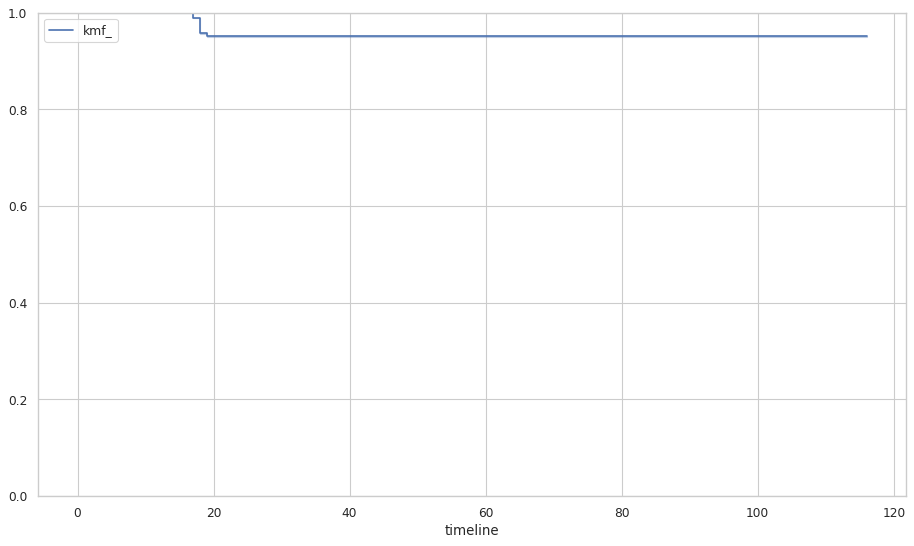

In [7]:
country_name, first_date, init_add = 'Germany', pd.to_datetime('2020-03-09'), 0.0
germany_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add, df=alternative_germany_data) 
germany_mortality_analysis.fit()
print(germany_mortality_analysis.print_death_rate())
germany_mortality_analysis.plot()

In [19]:
# germany_mortality_analysis.ll.shift_and_scale_popt

In [20]:
# germany_mortality_analysis.ll.plot_lead_lag()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


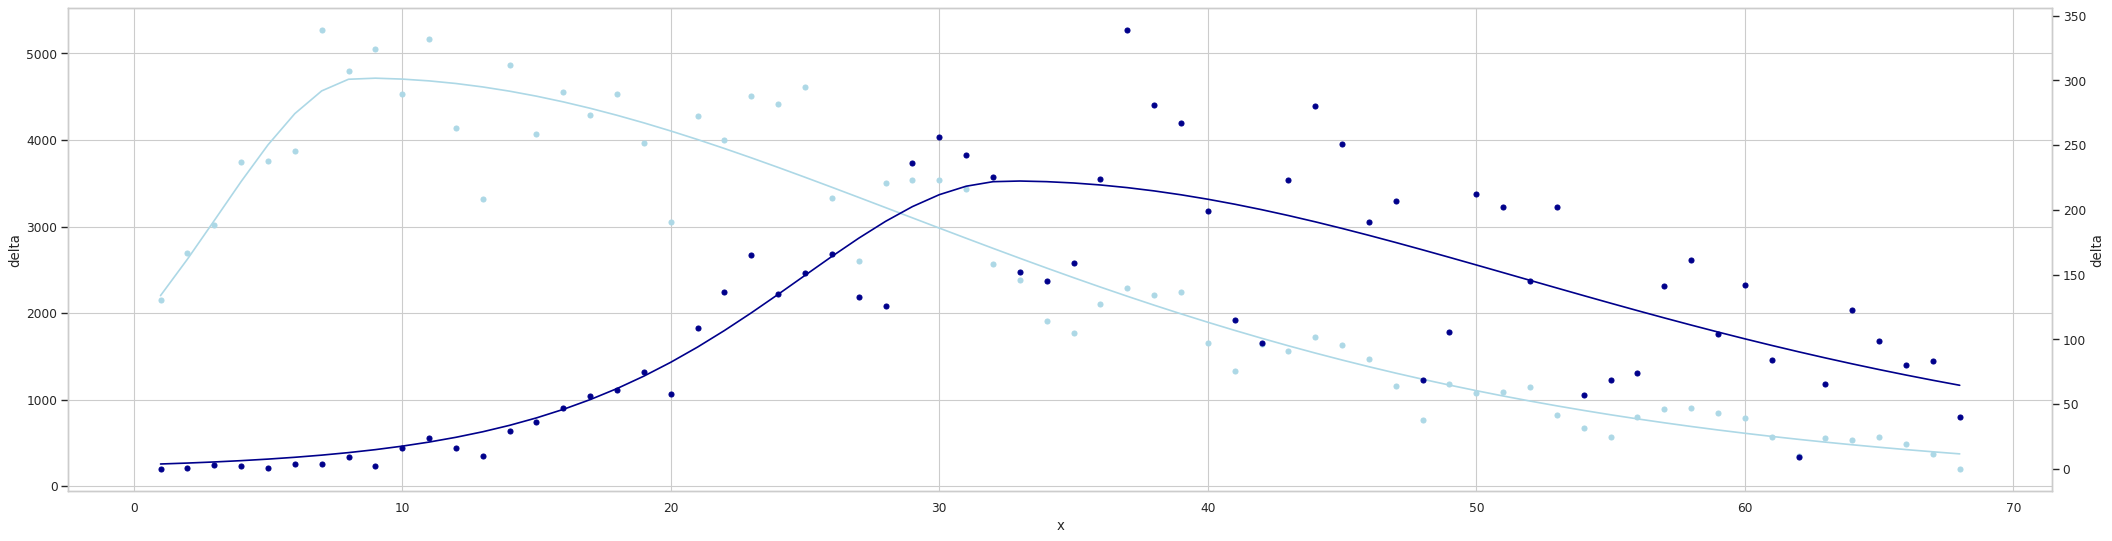

In [9]:
germany_mortality_analysis.plot_infection_and_death_curves()

In [8]:
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-19,176956,160281,8081,468,0,77
2020-05-20,177548,160281,8143,592,0,62
2020-05-21,177854,160281,8201,306,0,58
2020-05-22,178128,160280,8228,274,-1,27
2020-05-23,178258,160278,8259,130,-2,31


In [9]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,8681.0,8259,422.0,1746.0,83.0,21,2294.0


In [11]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,8472.0,7935,537.0,2484.0,118.0,21,3265.0


 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: `x0` is infeasible./ [663.91939956   0.12216088  -3.55429014]


CFR via Survival analysis: 3.88 (lower: 3.6, upper:4.19), CFR via shift and scale: 3.31 (time delay between infection and death: 14.35 days)


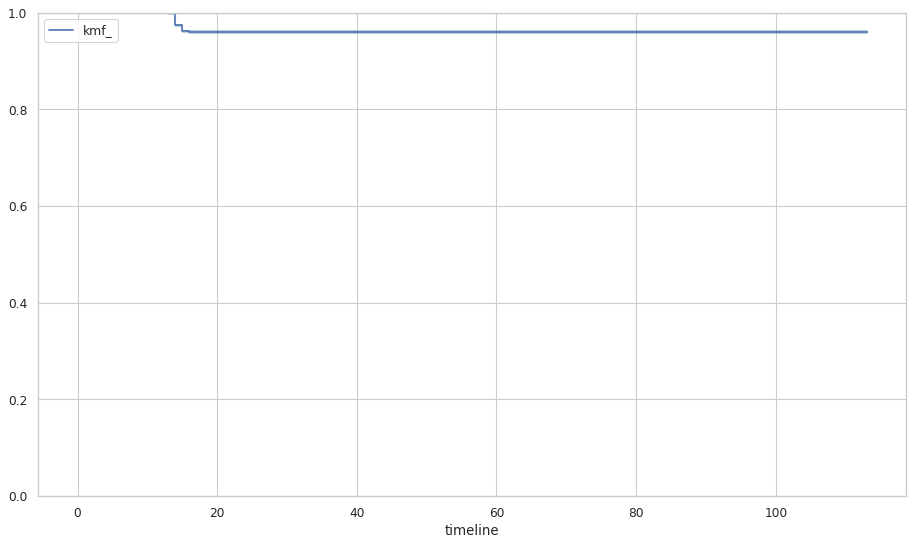

In [10]:
country_name, first_date, init_add = 'Austria', pd.to_datetime('2020-03-12'), 600
austria_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
austria_mortality_analysis.fit()
print(austria_mortality_analysis.print_death_rate())
austria_mortality_analysis.plot()

In [11]:
austria_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,16321,14678,632,52,64,3
2020-05-20,16353,14882,633,32,204,1
2020-05-21,16404,14951,633,51,69,0
2020-05-22,16436,15005,635,32,54,2
2020-05-23,16486,15037,639,50,32,4


In [12]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,663.0,639,24.0,49.0,2.0,21,64.0


In [14]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,654.0,629,25.0,66.0,3.0,21,87.0


 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: `x0` is infeasible./ [272.52152674   0.08205964  -8.46262351]


distribute_across_cases_gamma: using uniform distribution for date: 2020-03-04 00:00:00
CFR via Survival analysis: 2.43 (lower: 2.16, upper:2.74), CFR via shift and scale: 1.18 (time delay between infection and death: 23.12 days)


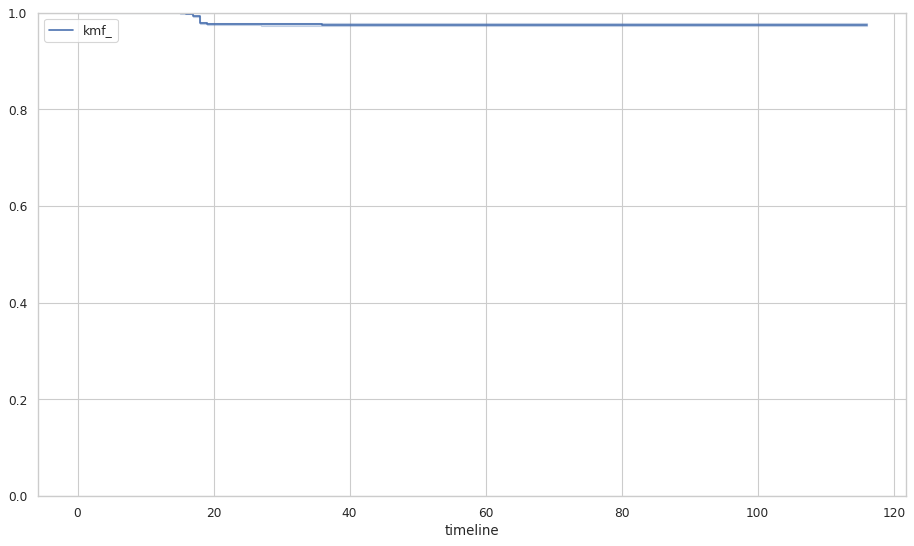

In [15]:
country_name, first_date, init_add = 'Korea, South', None, 0
south_korea_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
south_korea_mortality_analysis.fit()
# south_korea_mortality_analysis2 = covid19.MortalityAnalysis(south_korea_name, first_date=pd.to_datetime('2020-02-20'), init_add=900)
# south_korea_mortality_analysis2.fit()
print(south_korea_mortality_analysis.print_death_rate())
# print(south_korea_mortality_analysis2.death_rate())
# print(south_korea_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
south_korea_mortality_analysis.plot()

In [16]:
south_korea_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-12,10962,9695,259,26,25,1
2020-05-13,10991,9762,260,29,67,1
2020-05-14,11018,9821,260,27,59,0
2020-05-15,11037,9851,262,19,30,2
2020-05-16,11050,9888,262,13,37,0


In [20]:
# south_korea_mortality_analysis.prepend_df

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:2115: UserWarning:deaths must come after cases, ignore nonsensical fits


CFR via Survival analysis: 14.54 (lower: 14.4, upper:14.68), CFR via shift and scale: 14.72 (time delay between infection and death: -3.81 days)


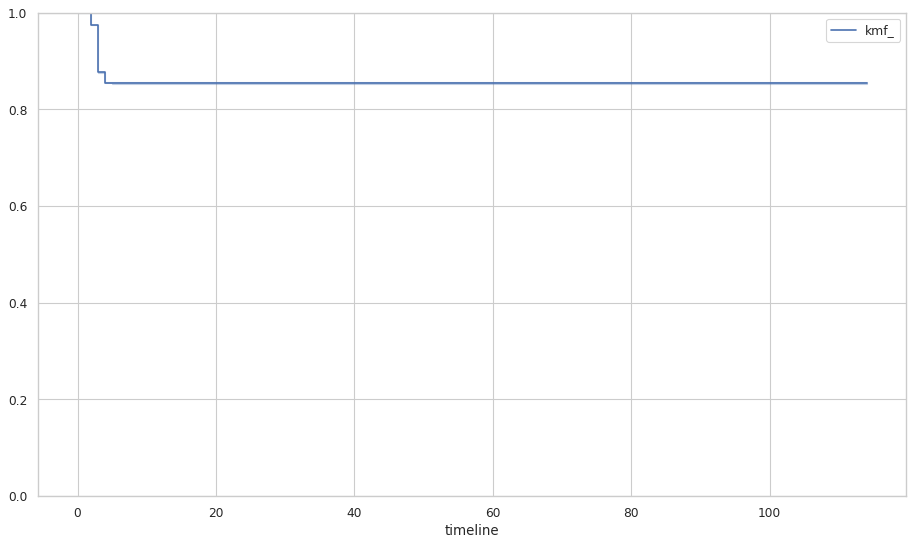

In [13]:
country_name, first_date, init_add = 'United Kingdom', pd.to_datetime('2020-03-05'), 800
uk_mortality_analysis  = covid19.MortalityAnalysis(country_name)
uk_mortality_analysis.fit()
print(uk_mortality_analysis.print_death_rate())
# uk_mortality_analysis2 = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add, mult=4.0)
# uk_mortality_analysis2.fit()
# print(uk_mortality_analysis2.death_rate())
# print(uk_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
uk_mortality_analysis.plot()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:2115: UserWarning:deaths must come after cases, ignore nonsensical fits


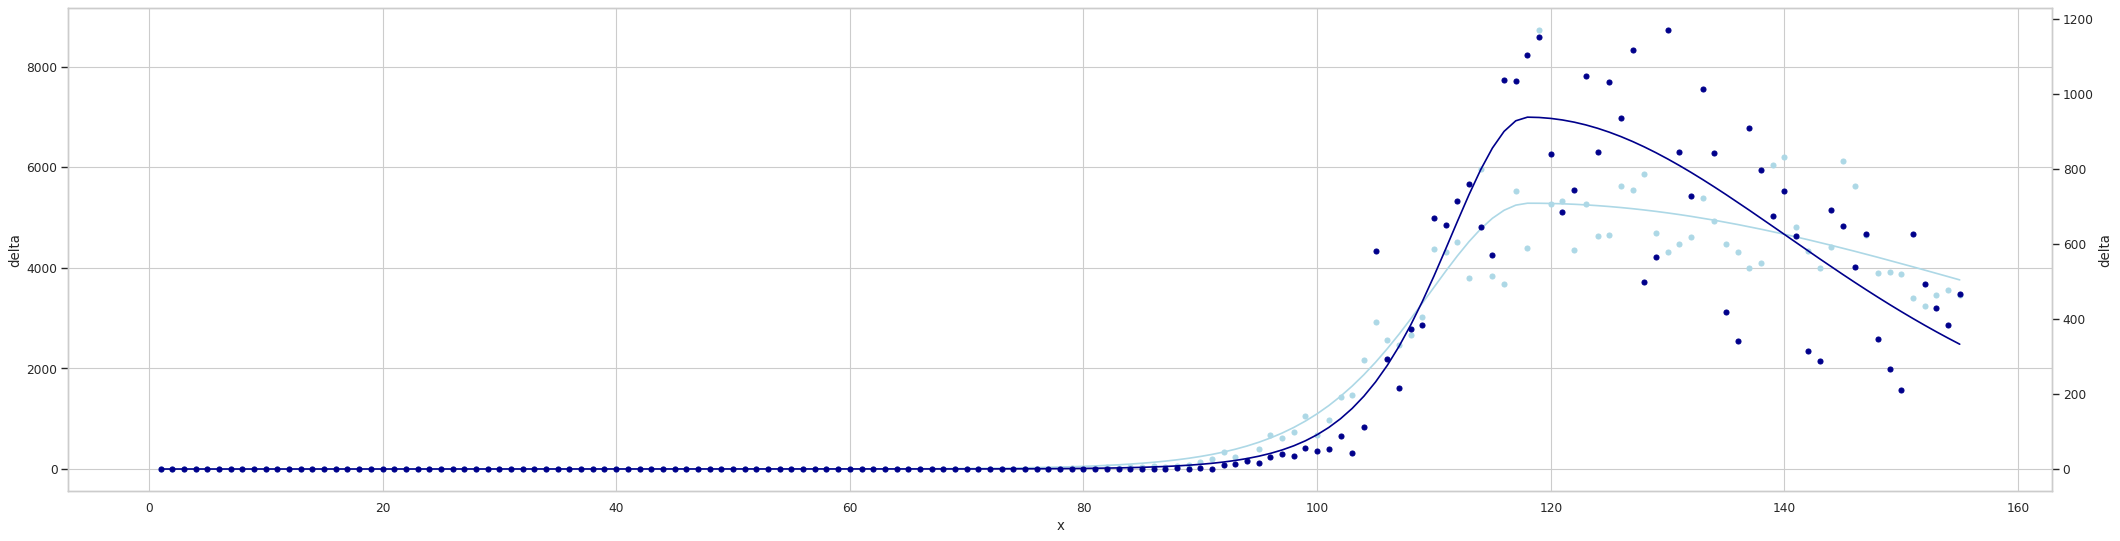

In [18]:
uk_mortality_analysis.plot_infection_and_death_curves()

In [14]:
uk_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,250138,1099,35422,2429,9,546
2020-05-20,249619,1116,35786,-519,17,364
2020-05-21,252246,1134,36124,2627,18,338
2020-05-22,255544,1142,36475,3298,8,351
2020-05-23,258504,1149,36757,2960,7,282


In [15]:
uk_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,37586.0,36757,829.0,12029.0,573.0,21,15809.0


In [20]:
uk_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,35591.0,34546,1045.0,14099.0,671.0,21,18530.0


In [30]:
# pd.options.mode.chained_assignment = "raise"

CFR via Survival analysis: 6.16 (lower: 6.12, upper:6.19), CFR via shift and scale: 6.29 (time delay between infection and death: 1.39 days)


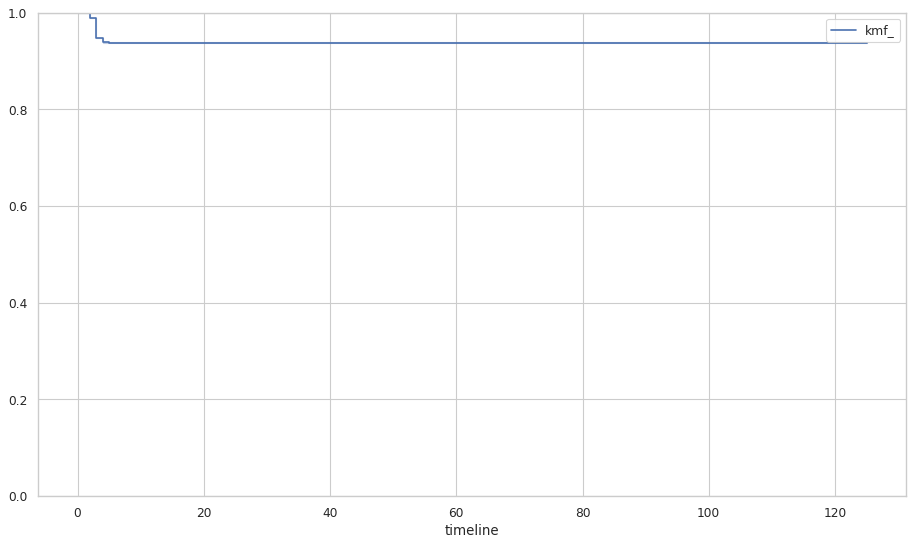

In [16]:
country_name, first_date, init_add = 'US', pd.to_datetime('2020-02-29'), 950
us_mortality_analysis  = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
us_mortality_analysis.fit()
# us_mortality_analysis2 = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=450, mult=1.5)
# us_mortality_analysis2.fit()
print(us_mortality_analysis.print_death_rate())
# print(us_mortality_analysis2.death_rate())
# print(us_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
us_mortality_analysis.plot()

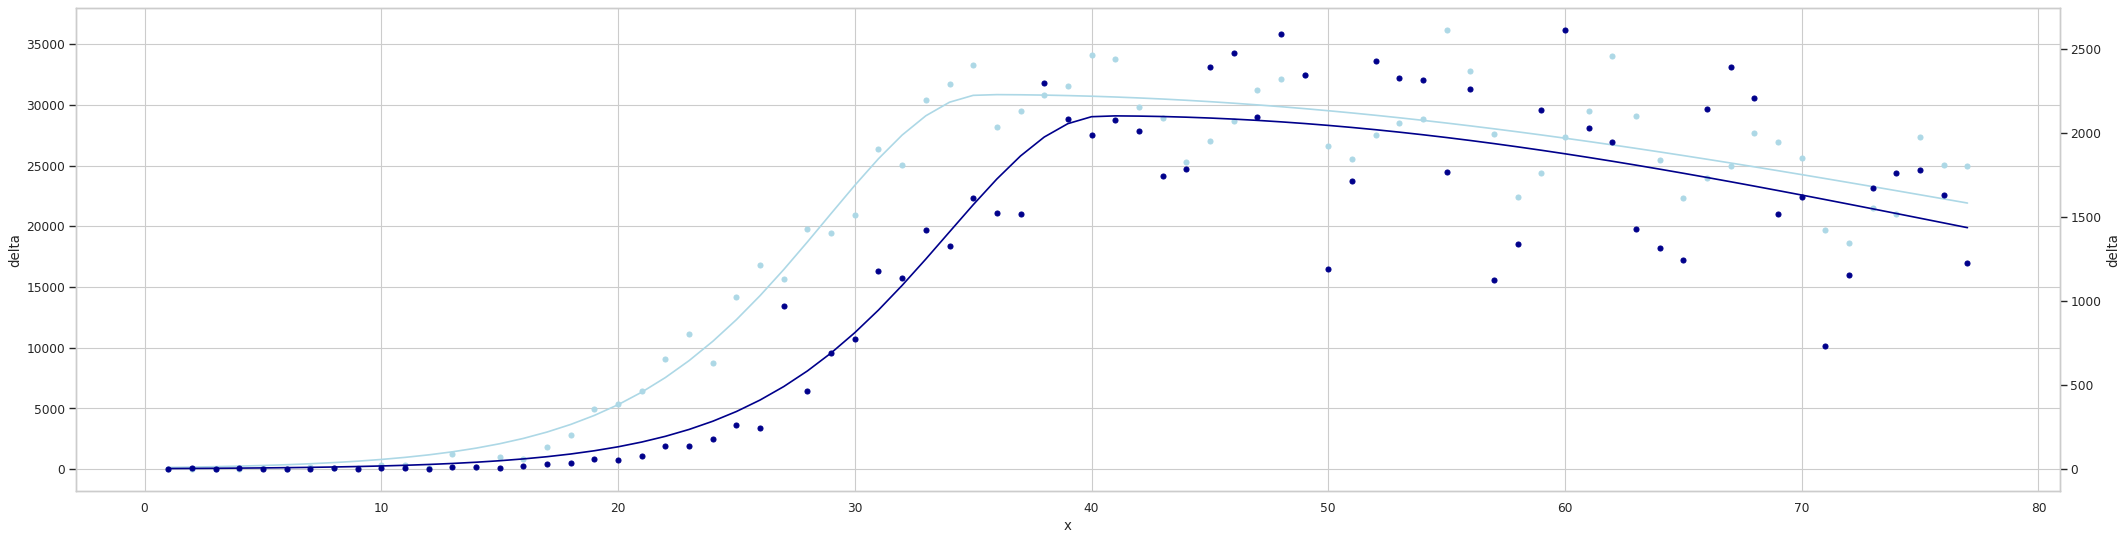

In [22]:
us_mortality_analysis.plot_infection_and_death_curves()

In [17]:
us_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,1528568,289392,91921,20260,6214,1574
2020-05-20,1551853,294312,93439,23285,4920,1518
2020-05-21,1577147,298418,94702,25294,4106,1263
2020-05-22,1600937,350135,95979,23790,51717,1277
2020-05-23,1622612,361239,97087,21675,11104,1108


In [18]:
us_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,100011.0,97087,2924.0,32616.0,1553.0,21,42866.0


In [24]:
us_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,91945.0,88754,3191.0,30191.0,1438.0,21,39679.0


In [19]:
alternative_italy_data = covid19.get_italy_df()
alternative_italy_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-05-19,226699,129401,32169,813,2075,162
2020-05-20,227364,132282,32330,665,2881,161
2020-05-21,228006,134560,32486,642,2278,156
2020-05-22,228658,136720,32616,652,2160,130
2020-05-23,229327,138840,32735,669,2120,119


CFR via Survival analysis: 14.4 (lower: 14.26, upper:14.54), CFR via shift and scale: 14.21 (time delay between infection and death: 3.99 days)


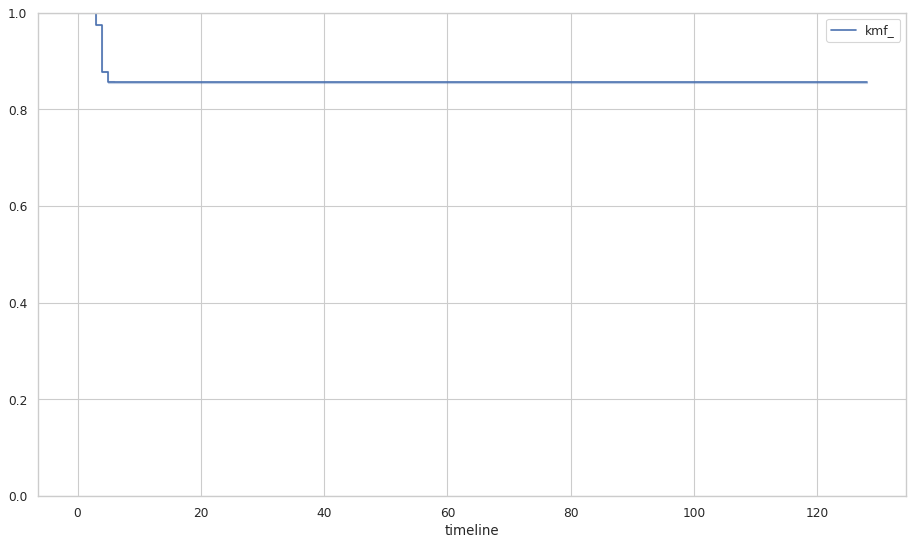

In [20]:
country_name, first_date, init_add = 'Italy', pd.to_datetime('2020-02-21'), 0
italy_mortality_analysis  = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add, df=alternative_italy_data)
italy_mortality_analysis.fit()
print(italy_mortality_analysis.print_death_rate())
# italy_mortality_analysis2  = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=2000, mult=4.0)
# italy_mortality_analysis2.fit()
# print(italy_mortality_analysis2.death_rate())
# print(italy_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
italy_mortality_analysis.plot()

In [21]:
italy_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-05-19,226699,129401,32169,813,2075,162
2020-05-20,227364,132282,32330,665,2881,161
2020-05-21,228006,134560,32486,642,2278,156
2020-05-22,228658,136720,32616,652,2160,130
2020-05-23,229327,138840,32735,669,2120,119


In [22]:
italy_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,33023.0,32735,288.0,4640.0,221.0,21,6098.0


In [28]:
italy_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,32118.0,31763,355.0,5896.0,281.0,21,7749.0


In [37]:
# italy_mortality_analysis2.prepend_df

In [23]:
alternative_spain_data = covid19.get_spain_df()
alternative_spain_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-19,279012,0,27793,464,0,100
2020-05-20,279662,0,27892,650,0,99
2020-05-21,280117,0,27940,455,0,48
2020-05-22,0,0,28628,0,0,688
2020-05-23,0,0,28678,0,0,50


CFR via Survival analysis: 10.24 (lower: 10.13, upper:10.35), CFR via shift and scale: 10.67 (time delay between infection and death: 2.53 days)


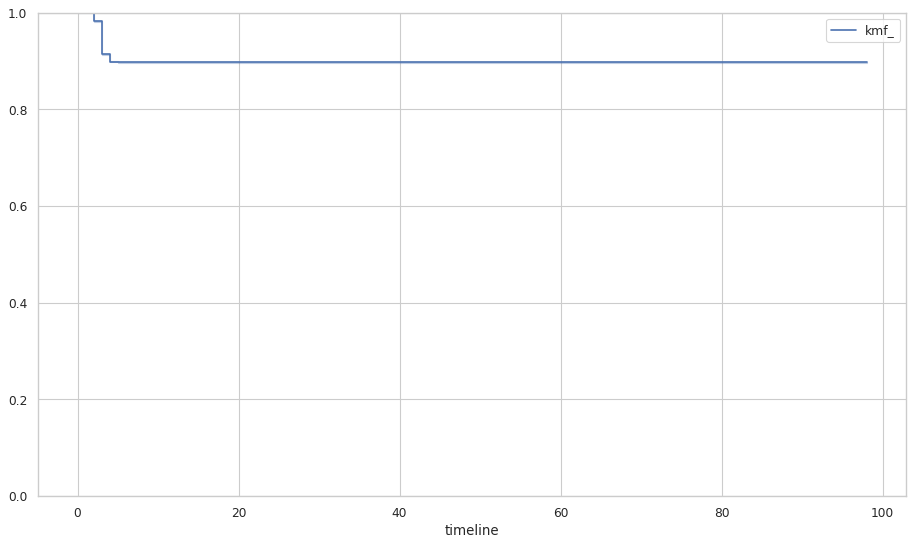

In [24]:
spain_mortality_analysis = covid19.MortalityAnalysis('Spain', df=alternative_spain_data)
spain_mortality_analysis.fit()
print(spain_mortality_analysis.print_death_rate())
# spain_mortality_analysis2 = covid19.MortalityAnalysis('Spain', first_date=pd.to_datetime('2020-03-03'), init_add=800, mult=3.0)
# spain_mortality_analysis2.fit()
# print(spain_mortality_analysis2.death_rate())
# print(spain_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
spain_mortality_analysis.plot()

In [25]:
spain_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-19,279012,0,27793,464,0,100
2020-05-20,279662,0,27892,650,0,99
2020-05-21,280117,0,27940,455,0,48
2020-05-22,0,0,28628,0,0,688
2020-05-23,0,0,28678,0,0,50


In [26]:
spain_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,0.0,28678,-28678.0,839.0,40.0,21,1102.0


In [32]:
spain_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,27977.0,27563,414.0,6742.0,321.0,21,8861.0


In [27]:
alternative_france_data = covid19.get_france_df()
alternative_france_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-05-19,143427,62563,28022,524,835,-217
2020-05-20,143845,63354,28132,418,791,110
2020-05-21,144163,63858,28215,318,504,83
2020-05-22,144556,64209,0,393,351,0
2020-05-23,144806,64547,0,250,338,0


CFR via Survival analysis: 16.43 (lower: 16.23, upper:16.62), CFR via shift and scale: 21.19 (time delay between infection and death: 5.29 days)


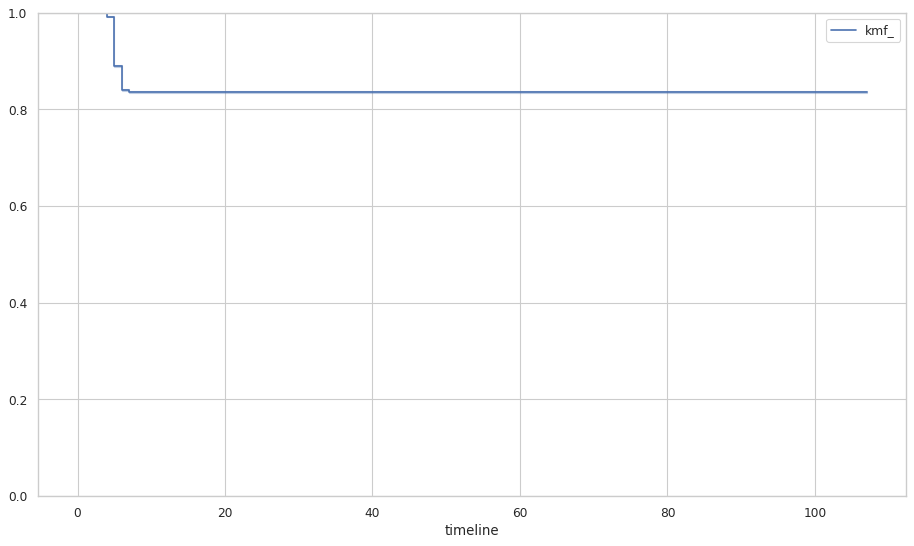

In [46]:
france_mortality_analysis = covid19.MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), df=alternative_france_data)
france_mortality_analysis.fit()
print(france_mortality_analysis.print_death_rate())
# france_mortality_analysis2 = covid19.MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), init_add=500, mult=4)
# france_mortality_analysis2.fit()
# print(france_mortality_analysis2.death_rate())
# print(france_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
france_mortality_analysis.plot()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 1000./ None
 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 1200./ None


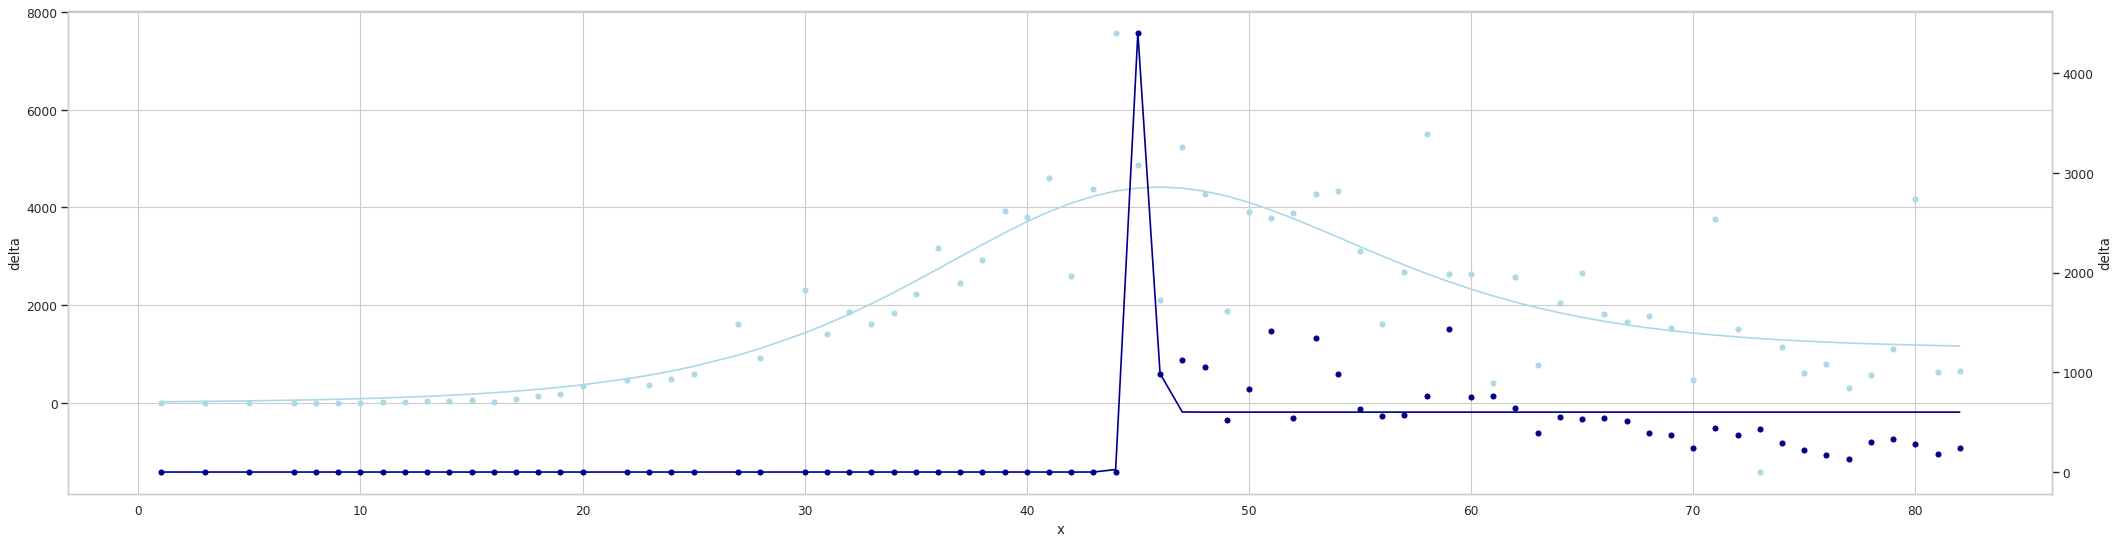

In [35]:
france_mortality_analysis.plot_infection_and_death_curves()

In [36]:
france_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-05-04,131863,51371,25201,576,587,306
2020-05-05,132967,52736,25531,1104,1365,330
2020-05-06,137150,53972,25809,4183,1236,278
2020-05-07,137779,55027,25987,629,1055,178
2020-05-08,138421,55782,26230,642,755,243


| date | note |
| --- | --- |
| 2020-04-20 | expected_death (17296.0) < today_death(19718); death rate via survival analysis (15.36) << death rate via affine transform of curve estimates (18.7) |
| 2020-04-21 | expected_death (17520.0) < today_death(20265); death rate via survival analysis (15.28) << death rate via affine transform of curve estimates (18.9) |
| 2020-04-24 | expected_death (19208.0) < today_death(21856); death rate via survival analysis (15.9) << death rate via affine transform of curve estimates (19.2) |

In [37]:
france_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,22687.0,26230,-3543.0,5818.0,277.0,21,7647.0


In [34]:
france_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,20616.0,24760,-4144.0,7843.0,373.0,21,10307.0


In [33]:
import rpy2
print(rpy2.__version__)

3.2.6


In [34]:
import rpy2.robjects.packages as rpackages
baseR = rpackages.importr('base')
print(baseR.R_Version().rx('version.string'))

$version.string
[1] "R version 3.6.1 (2019-07-05)"




In [35]:
# from rpy2.rinterface import R_VERSION_BUILD
# print(R_VERSION_BUILD)

In [36]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning:pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning:pandas >= 1.0 is not supported.
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:72: UserWarning:This was designed againt ggplot2 version 3.2.1 but you have 3.3.0
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/vectors.py:927: UserWarning:R object inheriting from "POSIXct" but without attribute "tzone".


In [37]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [38]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [39]:
def plot_lexis(mortality_analysis_instance):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~mortality_analysis_instance.df_lifelines_individual.observed_death
    ix_lost    = mortality_analysis_instance.df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_present], exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_present], colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_lost]   , exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_lost]   , colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

In [40]:
# plot_lexis(italy_mortality_analysis)

In [41]:
# plot_lexis(italy_mortality_analysis2)

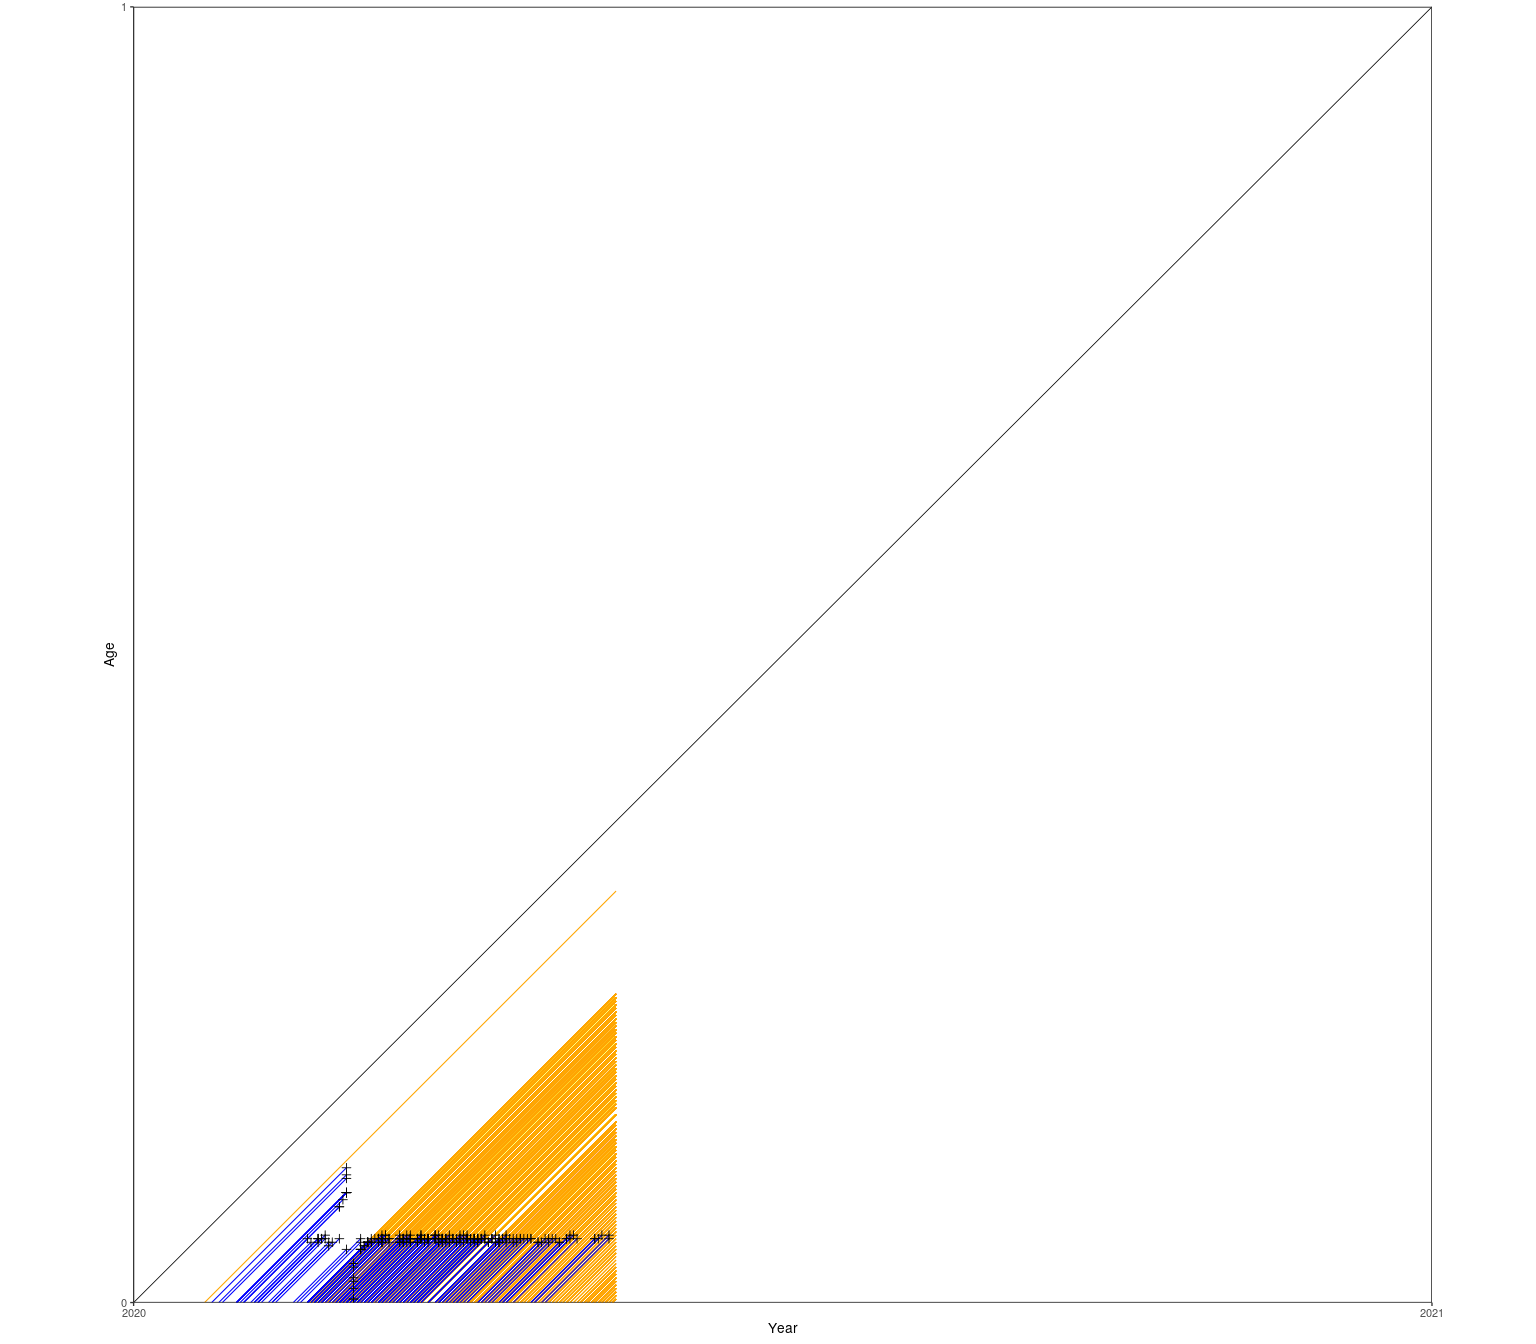

In [42]:
plot_lexis(south_korea_mortality_analysis)

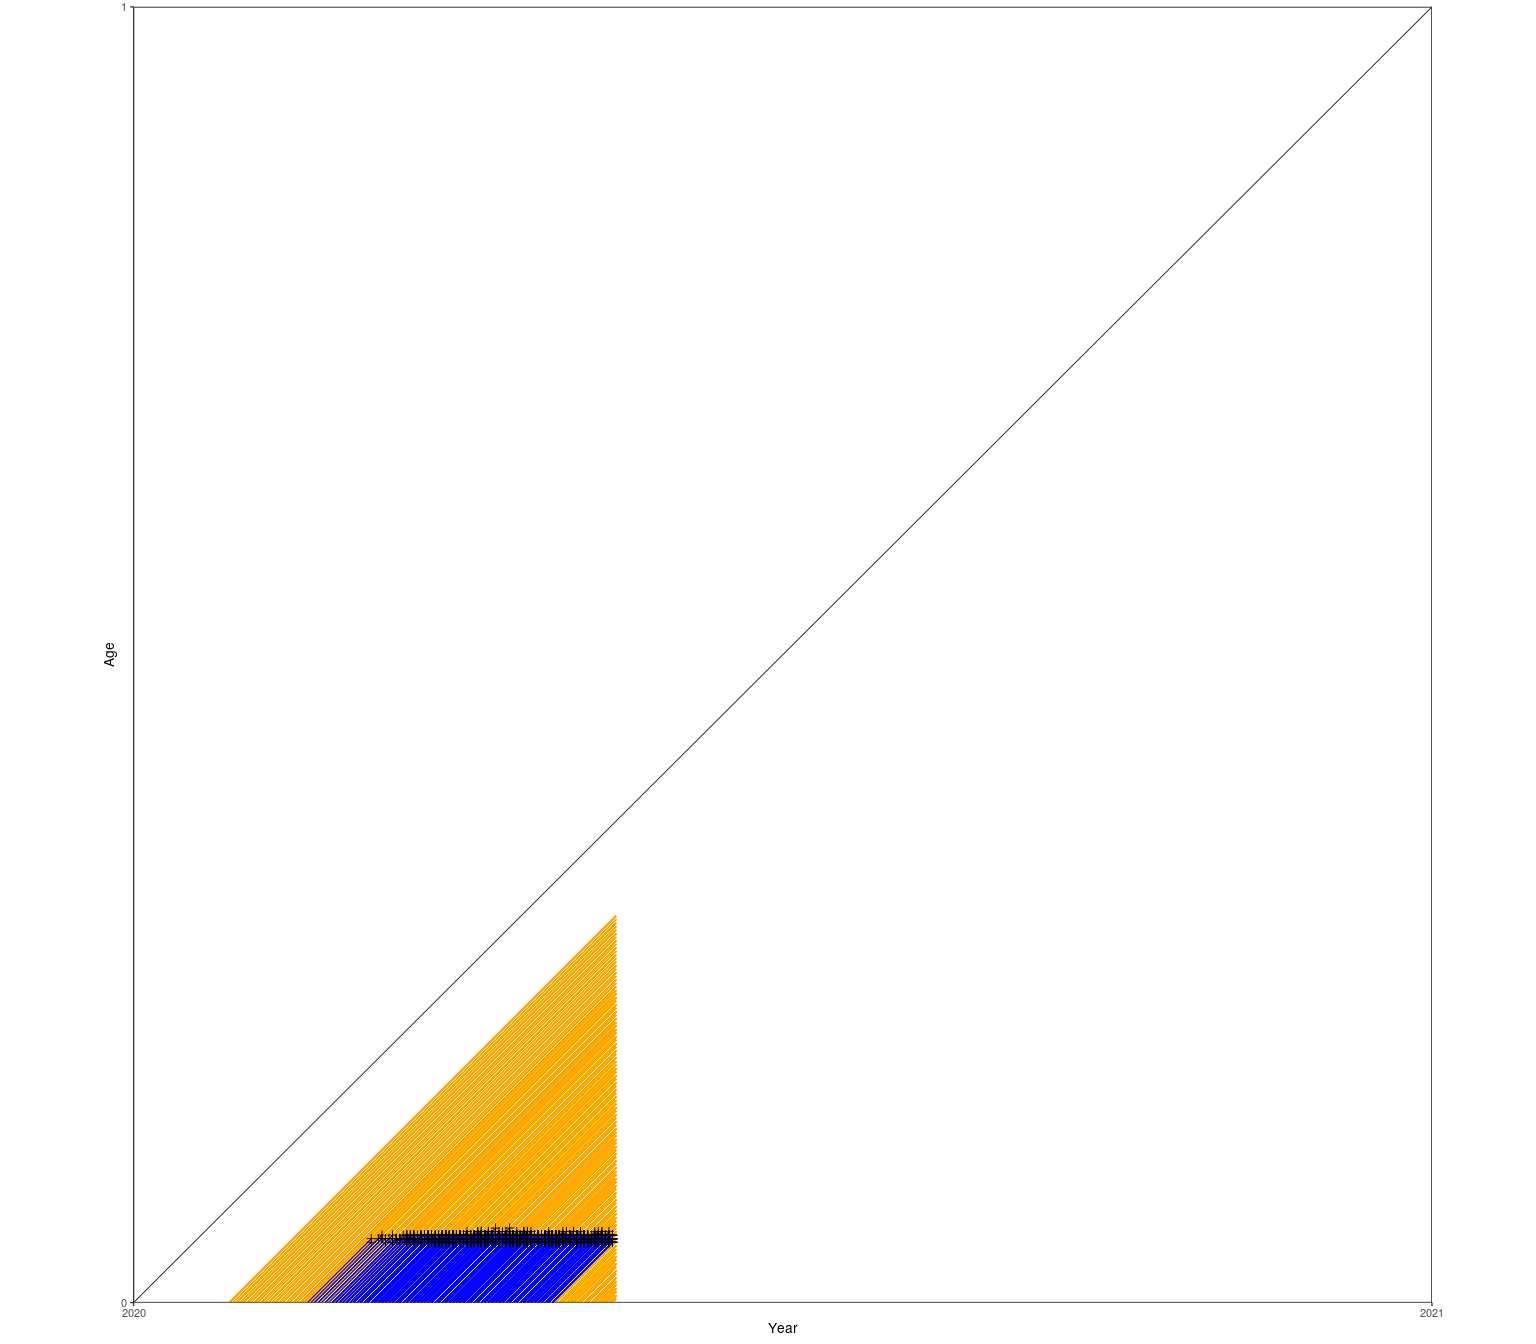

In [43]:
plot_lexis(germany_mortality_analysis)

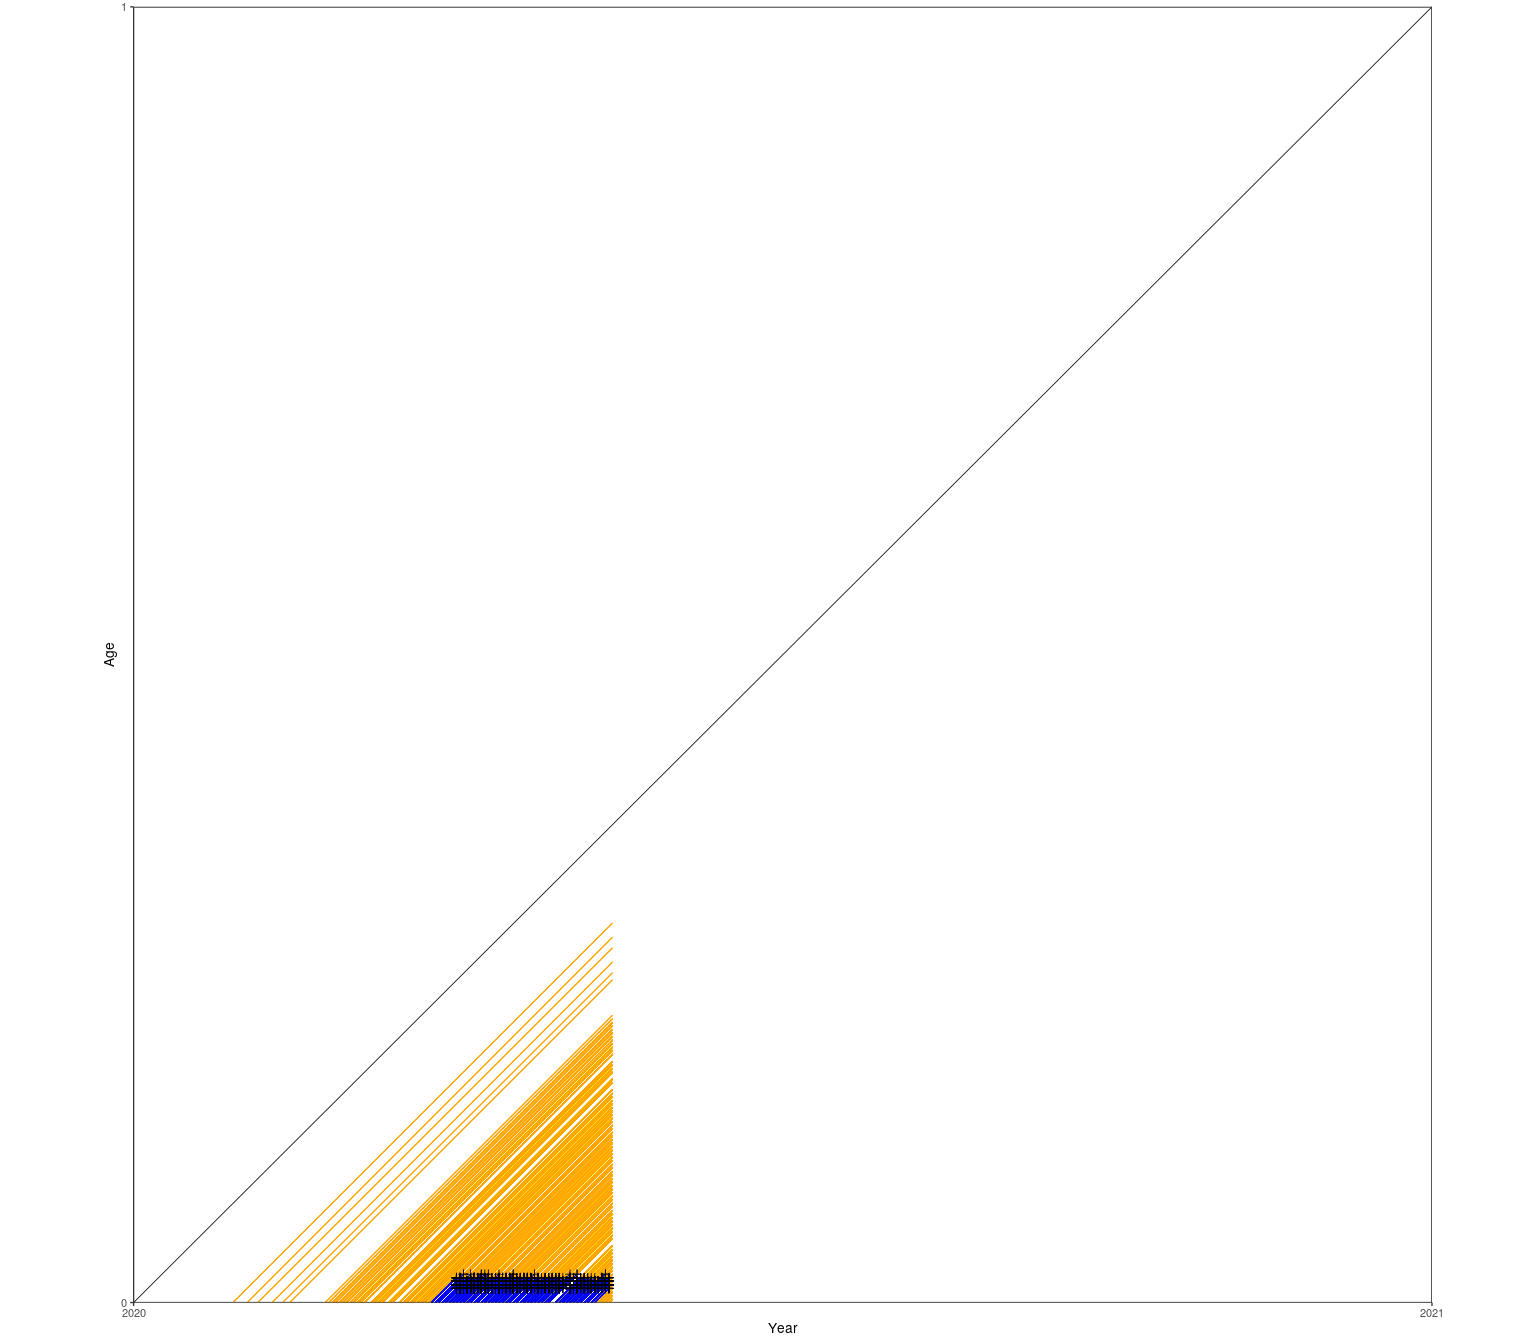

In [47]:
plot_lexis(france_mortality_analysis)